## 1. Calculate the gene expression score

In [ ]:
import os,gc
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np

os.chdir("/data/wuqinhua/scPhase/CRC")

adata = sc.read('./ensemble_adata_with_attention.h5ad')
print("read_over")

adata1 = adata[adata.obs['phenotype'] == "normal"]
adata2 = adata[adata.obs['phenotype'] == "MMRd"]
adata3 = adata[adata.obs['phenotype'] == "MMRp"]
print("split_over")

H_gene = pd.read_csv("./ensemble_gene_attributions_normal.csv") 
H_top_200 = H_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
H_bottom_200 = H_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata1, H_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata1, H_bottom_200, score_name='gene_ex_score_bottom')
adata1.obs.to_csv('./Analysis/Figure/gene_ex_scores_normal_top_bottom_200.csv')
print("Phenotype Not_AD scores saved.")

M_gene = pd.read_csv("./ensemble_gene_attributions_MMRd.csv") 
M_top_200 = M_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
M_bottom_200 = M_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata2, M_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata2, M_bottom_200, score_name='gene_ex_score_bottom')
adata2.obs.to_csv('./Analysis/Figure/gene_ex_scores_MMRd_top_bottom_200.csv')
print("Phenotype Low scores saved.")

S_gene = pd.read_csv("./ensemble_gene_attributions_MMRp.csv") 
S_top_200 = S_gene.sort_values(by='mean_attribution', ascending=False).head(200)['gene'].tolist()
S_bottom_200 = S_gene.sort_values(by='mean_attribution', ascending=True).head(200)['gene'].tolist()
sc.tl.score_genes(adata3, S_top_200, score_name='gene_ex_score_top')
sc.tl.score_genes(adata3, S_bottom_200, score_name='gene_ex_score_bottom')
adata3.obs.to_csv('./Analysis/Figure/gene_ex_scores_MMRp_top_bottom_200.csv')
print("Phenotype Intermediate scores saved.")

print("\nAll processing complete.")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: 

read_over
split_over


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Not_AD scores saved.


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Low scores saved.


/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Phenotype Intermediate scores saved.

All processing complete.


In [1]:
library(dplyr)
library(tidyr)
library(reshape2)
library(ggplot2)
library(ggrepel)
library(scales)
setwd("/data/wuqinhua/scPhase/CRC")

attnData <- read.csv('./CRC_metadata.csv')
sampleInfo = read.csv('./sample_info.csv')

nameAll = unique(attnData$cl295v11SubFull)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(cl295v11SubFull) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$cl295v11SubFull,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table <- dcast(sampleFold, id ~ celltype)
rownames(sampleFold.Table) <- sampleFold.Table$id
sampleFold.Table$id <- NULL
attn <- sampleFold.Table


ex_H <- read.csv('./Analysis/Figure/gene_ex_scores_normal_top_bottom_200.csv')
ex_M <- read.csv('./Analysis/Figure/gene_ex_scores_MMRd_top_bottom_200.csv')
ex_S <- read.csv("./Analysis/Figure/gene_ex_scores_MMRp_top_bottom_200.csv")

exData <- rbind(ex_H, ex_M, ex_S)

process_expression_data <- function(exData, sample_id_col, gene_ex_score_col) {
  nameAll <- unique(exData$cl295v11SubFull)
  nameList <- sort(nameAll)
  
  sampleFold <- data.frame(id = character(), celltype = character(), fold = numeric())
  idList <- unique(exData[[sample_id_col]])
  
  for (id in idList) {
    attnTmp <- exData %>% filter(.data[[sample_id_col]] == id)
    foldRes <- attnTmp %>% group_by(cl295v11SubFull) %>% summarise(res = median(.data[[gene_ex_score_col]]))
    dataTmp <- data.frame(id = rep(id, dim(foldRes)[1]),
                         celltype = foldRes$cl295v11SubFull,
                         fold = foldRes$res)
    dataTmp_s <- dataTmp %>% filter(celltype %in% nameList)
    sampleFold <- rbind(sampleFold, dataTmp_s)
  }
  
  ex_sampleFold.Table <- dcast(sampleFold, id ~ celltype)
  rownames(ex_sampleFold.Table) <- ex_sampleFold.Table$id
  ex_sampleFold.Table$id <- NULL
  return(ex_sampleFold.Table)
}

ex_top <- process_expression_data(exData, 'sample_id', 'gene_ex_score_top')
ex_bottom <- process_expression_data(exData, 'sample_id', 'gene_ex_score_bottom')
sampleInfo <- sampleInfo[rownames(attn), ]
ex_top <- ex_top[rownames(attn), colnames(attn)]
ex_bottom <- ex_bottom[rownames(attn), colnames(attn)]

ex_diff <- ex_top - ex_bottom
custom_colors <- c("normal" = "#A2D8A2", "MMRd" = "#B8D8F1", "MMRp" = "#F5B54F")

sampleInfo = read.csv('/data/wuqinhua/phase_1r/CRC/sample_info.csv')

attn_long <- attn %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "attn_value")

ex_diff_long <- ex_diff %>%
  tibble::rownames_to_column("sample") %>%
  pivot_longer(cols = -sample, names_to = "cell_type", values_to = "ex_diff_value")

plot_data_long <- attn_long %>%
  left_join(ex_diff_long, by = c("sample", "cell_type")) %>%
  left_join(sampleInfo %>% select(sample_id, phenotype), by = c("sample" = "sample_id")) %>%
  mutate(group = factor(phenotype, levels = names(custom_colors))) %>%
  na.omit()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




[1] "cB1 (B IGD+IgM+)"                    "cB2 (B GC-like)"                    
 [3] "cB3 (B CD40+ GC-like)"               "cE01 (Stem/TA-like)"                
 [5] "cE02 (Stem/TA-like/Immature Goblet)" "cE03 (Stem/TA-like prolif)"         
 [7] "cE04 (Enterocyte 1)"                 "cE05 (Enterocyte 2)"                
 [9] "cE06 (Immature Goblet)"              "cE07 (Goblet/Enterocyte)"           
[11] "cE08 (Goblet)"                       "cE09 (Best4)"                       
[13] "cE10 (Tuft)"                         "cE11 (Enteroendocrine)"             
[15] "cM01 (Monocyte)"                     "cM02 (Macrophage-like)"             
[17] "cM03 (DC1)"                          "cM04 (DC2)"                         
[19] "cM05 (DC2 C1Q+)"                     "cM06 (DC IL22RA2)"                  
[21] "cM07 (pDC)"                          "cM08 (AS-DC)"                       
[23] "cM09 (mregDC)"                       "cM10 (Granulocyte)"                 
[25] "cMA01 (Mast)"                        "cP1 (Plasma IgA)"                   
[27] "cP2 (Plasma IgG)"                    "cP3 (Plasma IgG prolif)"            
[29] "cS01 (Endo arterial)"                "cS02 (Endo capillary)"              
[31] "cS03 (Endo capillary)"               "cS04 (Endo)"                        
[33] "cS05 (Endo venous)"                  "cS06 (Endo lymphatic)"              
[35] "cS07 (Endo capillary-like)"          "cS08 (Endo arterial-like)"          
[37] "cS09 (Endo)"                         "cS10 (Endo tip cells)"              
[39] "cS11 (Endo proif)"                   "cS12 (Endo)"                        
[41] "cS13 (Endo venous-like)"             "cS14 (Endo)"                        
[43] "cS15 (Pericyte)"                     "cS16 (Pericyte)"                    
[45] "cS17 (Pericyte)"                     "cS18 (Pericyte)"                    
[47] "cS19 (Pericyte)"                     "cS20 (Pericyte prolif)"             
[49] "cS21 (Fibro stem cell niche)"        "cS22 (Fibro stem cell niche)"       
[51] "cS23 (Fibro BMP-producing)"          "cS24 (Fibro BMP-producing)"         
[53] "cS25 (Fibro CCL8+)"                  "cS26 (Myofibro)"                    
[55] "cS27 (CXCL14+ CAF)"                  "cS28 (GREM1+ CAF)"                  
[57] "cS29 (MMP3+ CAF)"                    "cS30 (CAF CCL8 Fibro-like)"         
[59] "cS31 (CAF stem niche Fibro-like)"    "cS32 (Smooth Muscle)"               
[61] "cS33 (Schwann)"                      "cTNI01 (CD4+ IL7R+)"                
[63] "cTNI02 (CD4+ IL7R+SELL+)"            "cTNI03 (CD4+ IL7R+HSP+)"            
[65] "cTNI04 (CD4+ IL7R+CCL5+)"            "cTNI05 (CD4+ IL17+)"                
[67] "cTNI06 (CD4+ TFH)"                   "cTNI07 (CD4+ CXCL13+)"              
[69] "cTNI08 (CD4+ Treg)"                  "cTNI09 (CD4+ Treg prolif)"          
[71] "cTNI10 (CD8+ IL7R+)"                 "cTNI11 (CD8+GZMK+)"                 
[73] "cTNI12 (CD8+ IL7R+)"                 "cTNI13 (CD8+ T IL17+)"              
[75] "cTNI14 (CD8+ CXCL13+)"               "cTNI15 (CD8+ CXCL13+ HSP+)"         
[77] "cTNI16 (CD8+ CXCL13+ prolif)"        "cTNI17 (gd-like T)"                 
[79] "cTNI18 (gd-like T PDCD1+)"           "cTNI19 (gd-like T prolif)"          
[81] "cTNI20 (PLZF+ T)"                    "cTNI21 (PLZF+ T prolif)"            
[83] "cTNI22 (cTNI22)"                     "cTNI23 (NK CD16A+)"                 
[85] "cTNI24 (NK GZMK+)"                   "cTNI25 (NK XCL1+)"                  
[87] "cTNI26 (ILC3)"

Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.

Using fold as value column: use value.var to override.



`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


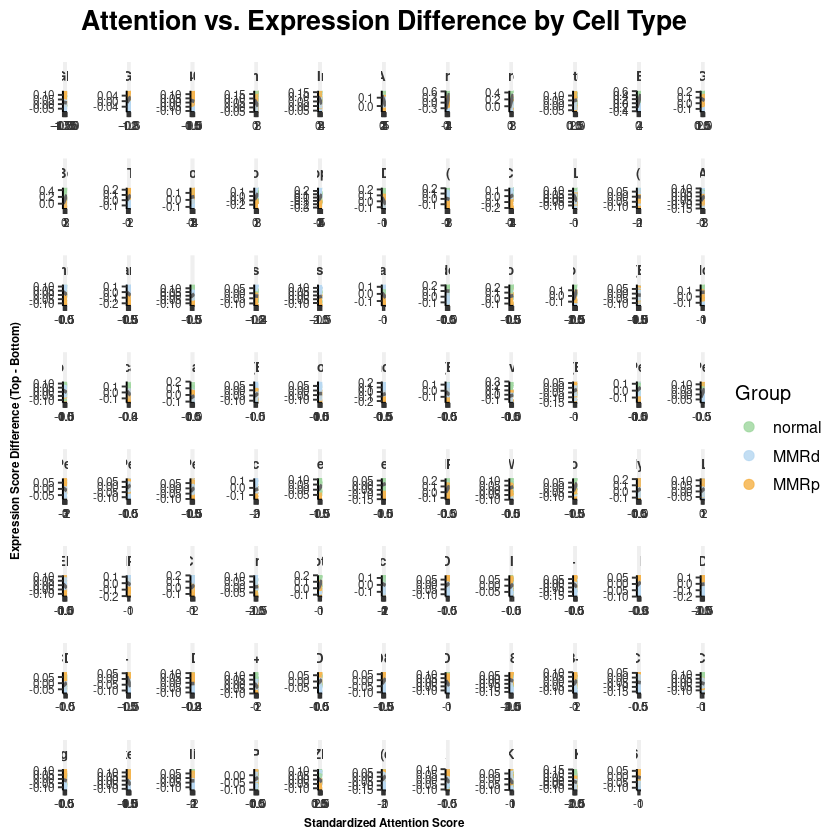

In [2]:
annotation_data <- plot_data_long %>%
  group_by(cell_type) %>%
  summarise(
    cor_test_res = list(cor.test(attn_value, ex_diff_value, method = "pearson")),
    pcc_value = cor_test_res[[1]]$estimate,
    p_value = cor_test_res[[1]]$p.value
  ) %>%
  mutate(
    significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE ~ ""
    ),
    title_with_sig = paste0(cell_type, " ", significance),

    label_string = paste0("PCC = ", round(pcc_value, 3), 
                          ", ", 
                          scales::pvalue(p_value, accuracy = 0.001, add_p = TRUE))
  )

plot_data_final <- plot_data_long %>%
  left_join(annotation_data %>% select(cell_type, title_with_sig), by = "cell_type")

final_plot <- ggplot(plot_data_final, aes(x = attn_value, y = ex_diff_value)) +
  
  geom_point(aes(color = group), alpha = 0.85, size = 2.5 ) +
  
  geom_smooth(
    method = "lm", se = TRUE,
    color = "#666666", fill = "#C9C9C9",
    alpha = 0.25, linewidth = 1
  ) +
  
  geom_text(
    data = annotation_data, 
    aes(label = label_string), 
    x = -Inf, y = Inf,     
    hjust = -0.1, vjust = 1.5,
    size = 2
  ) +
  
  scale_color_manual(values = custom_colors, name = "Group") +

  facet_wrap(~title_with_sig, scales = "free",ncol = 11,nrow = 8) +
  
  labs(
    title = "Attention vs. Expression Difference by Cell Type",
    x = "Standardized Attention Score",
    y = "Expression Score Difference (Top - Bottom)"
  ) +
  
  theme_classic(base_size = 12) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background  = element_rect(fill = "white", color = NA),
    # panel.grid.major = element_line(color = "grey92", linewidth = 0.5),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 8, face = "bold", color = "#333333"),
    axis.text = element_text(size =7, color = "#333333"),
    axis.title = element_text(size = 7, face = "bold"),
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold", margin = ggplot2::margin(b = 15)),
    panel.spacing = unit(1, "lines")
  )


ggsave("./Analysis/Figure/Con_plot/correlation_faceted_plot.pdf",
       final_plot, width = 30, height = 22, dpi = 300)

print(final_plot)